Random Forest Regression Analysis

Fathurazka Gamma Syuhada - 5025221128

Objective: Membuat model yang dapat memprediksi "social media addiction" siswa berdasarkan attribute yang tersedia menggunakan algoritma random forest

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Load and Explore the Dataset
print("LOADING AND EXPLORING DATASET")
print("=" * 50)

# Load the preprocessed dataset
df = pd.read_csv('../dataset/students_social_media_preprocessed.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

print("\nBasic statistics:")
print(df.describe().T)

print("\nMissing values check:")
print(df.isnull().sum().sum(), "missing values found")

C:\Users\Fathurazka Gamma\AppData\Local\Temp\ipykernel_23184\1797022924.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


LOADING AND EXPLORING DATASET
Dataset Shape: (705, 64)

First 5 rows:
        Age  Avg_Daily_Usage_Hours  Sleep_Hours_Per_Night  \
0 -1.186915               0.223857              -0.327638   
1  0.958662              -2.243309               0.560423   
2 -0.471723               0.860545              -1.659730   
3 -1.902108              -1.527035               0.116393   
4  0.243470              -0.333245              -0.771668   

   Mental_Health_Score  Conflicts_Over_Social_Media  Addicted_Score  \
0            -0.205520                     0.157063        0.985550   
1             1.605628                    -2.976790       -2.166958   
2            -1.111095                     1.201681        1.616052   
3             0.700054                    -1.932172       -1.536456   
4            -0.205520                    -0.887554        0.355048   

   Gender_Encoded  Affects_Academic_Performance_Encoded  \
0               0                                     1   
1               1 

Exploratory Data Analysis (EDA)



EXPLORATORY DATA ANALYSIS

Target variable 'Addicted_Score' statistics:
count    7.050000e+02
mean    -1.209434e-16
std      1.000710e+00
min     -2.797459e+00
25%     -9.059547e-01
50%      3.550484e-01
75%      9.855500e-01
max      1.616052e+00
Name: Addicted_Score, dtype: float64


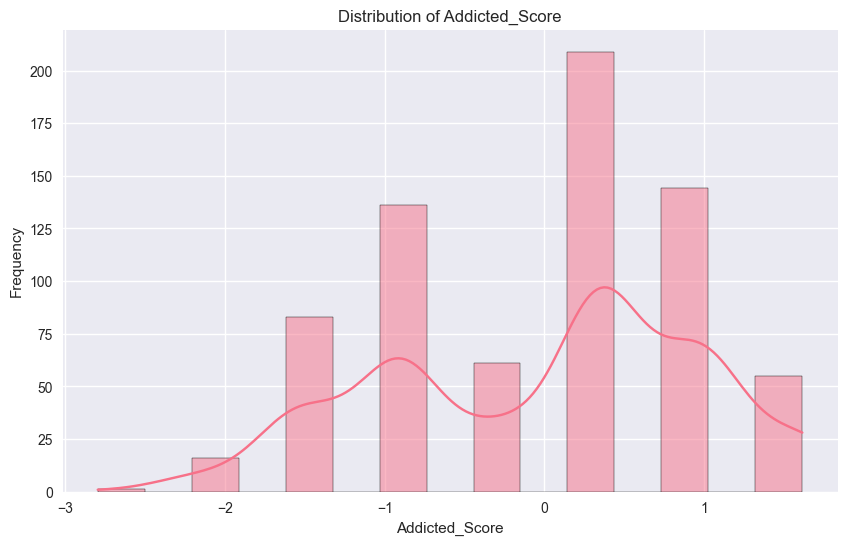


Top 10 features correlated with Addicted_Score:
Addicted_Score                          1.000000
Conflicts_Over_Social_Media             0.933586
SM_Impact_Score                         0.913976
Affects_Academic_Performance_Encoded    0.866049
Avg_Daily_Usage_Hours                   0.832000
Usage_Category_Encoded                  0.755325
Country_USA                             0.334492
Platform_TikTok                         0.330558
Country_Frequency                       0.236864
Academic_Level_High School              0.201333
Country_India                           0.192806
Name: Addicted_Score, dtype: float64


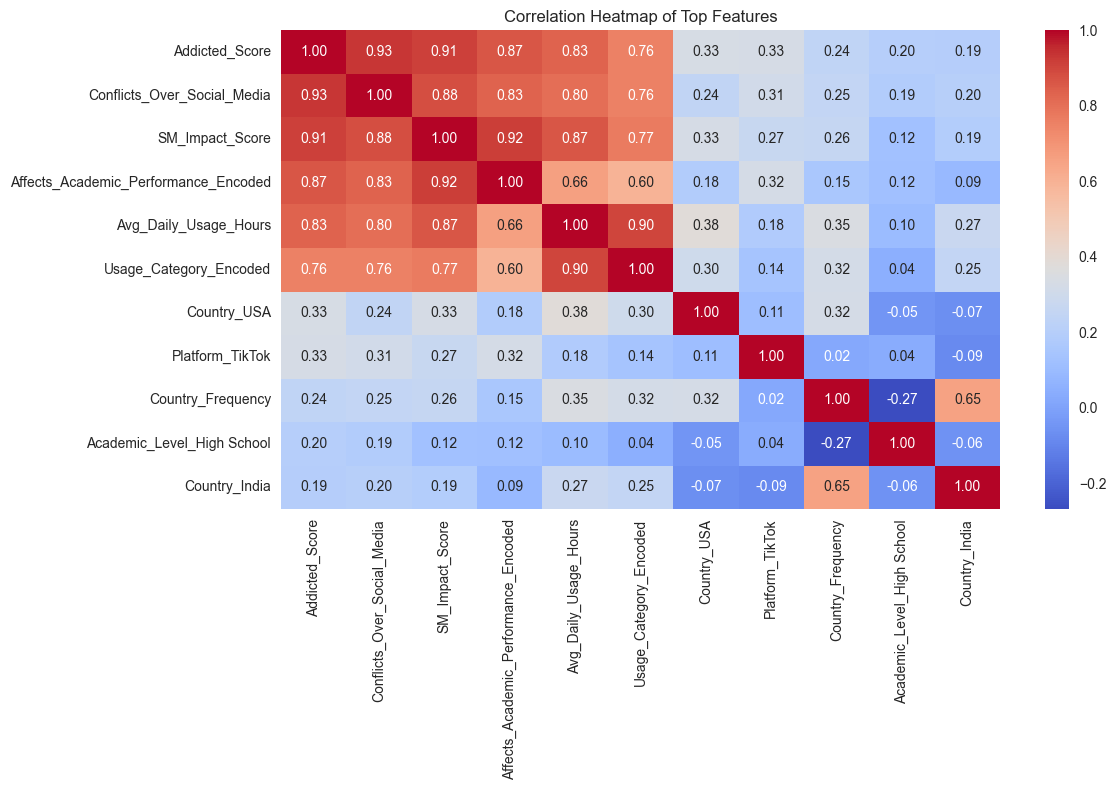



FEATURE SELECTION

Feature set shape: (705, 63)
Target shape: (705,)


In [2]:
# 2. Exploratory Data Analysis
print("\n\nEXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Target variable analysis
target = 'Addicted_Score'
print(f"\nTarget variable '{target}' statistics:")
print(df[target].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df[target], kde=True, bins=15)
plt.title(f'Distribution of {target}')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.show()

# Correlation analysis
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation = df[numeric_columns].corr()

# Get top 10 features most correlated with target
top_corr = correlation[target].sort_values(ascending=False)
print("\nTop 10 features correlated with Addicted_Score:")
print(top_corr[:11])  # 11 because the first one is the target itself

# Plot correlation heatmap for top features
plt.figure(figsize=(12, 8))
top_features = top_corr[:11].index
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()

# 3. Feature Selection
print("\n\nFEATURE SELECTION")
print("=" * 50)

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

# Split the dataset for feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nFeature set shape: {X.shape}")
print(f"Target shape: {y.shape}")

Random Forest Model with Hyperparameter Tuning

In [3]:
# 4. Model Building and Hyperparameter Tuning
print("\n\nMODEL BUILDING AND HYPERPARAMETER TUNING")
print("=" * 50)

# Initial model with default parameters
print("Training initial model with default parameters...")
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train, y_train)

# Evaluate initial model
y_pred_default = rf_default.predict(X_test)
mse_default = mean_squared_error(y_test, y_pred_default)
r2_default = r2_score(y_test, y_pred_default)
mae_default = mean_absolute_error(y_test, y_pred_default)

print(f"Default Model Performance:")
print(f"Mean Squared Error: {mse_default:.4f}")
print(f"R² Score: {r2_default:.4f}")
print(f"Mean Absolute Error: {mae_default:.4f}")

# Hyperparameter tuning with GridSearchCV
print("\nPerforming hyperparameter tuning with GridSearchCV...")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)

# Evaluate tuned model
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"\nTuned Model Performance:")
print(f"Mean Squared Error: {mse_tuned:.4f}")
print(f"R² Score: {r2_tuned:.4f}")
print(f"Mean Absolute Error: {mae_tuned:.4f}")

# Improvement from default model
mse_improvement = ((mse_default - mse_tuned) / mse_default) * 100
r2_improvement = ((r2_tuned - r2_default) / r2_default) * 100 if r2_default > 0 else 0
mae_improvement = ((mae_default - mae_tuned) / mae_default) * 100

print(f"\nImprovement from Default Model:")
print(f"MSE Improvement: {mse_improvement:.2f}%")
print(f"R² Improvement: {r2_improvement:.2f}%")
print(f"MAE Improvement: {mae_improvement:.2f}%")



MODEL BUILDING AND HYPERPARAMETER TUNING
Training initial model with default parameters...
Default Model Performance:
Mean Squared Error: 0.0077
R² Score: 0.9922
Mean Absolute Error: 0.0219

Performing hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Tuned Model Performance:
Mean Squared Error: 0.0077
R² Score: 0.9922
Mean Absolute Error: 0.0219

Improvement from Default Model:
MSE Improvement: 0.39%
R² Improvement: 0.00%
MAE Improvement: 0.00%


Feature Importance Analysis and Model Validation

In [ ]:
# 5. Feature Importance Analysis
print("\n\nFEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance from the model
feature_importances = best_rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Top 15 most important features:")
print(feature_importance_df.head(15))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

# Permutation importance for more robust feature importance
print("\nCalculating permutation importance...")
perm_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 features by permutation importance:")
print(perm_importance_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15))
plt.title('Top 15 Features by Permutation Importance')
plt.tight_layout()
plt.show()

# 6. Model Validation with Cross-Validation
print("\n\nMODEL VALIDATION WITH CROSS-VALIDATION")
print("=" * 50)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R² Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# MSE cross-validation
cv_scores_mse = cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores_mse  # Convert to positive MSE
print(f"\nCross-Validation MSE Scores: {cv_mse_scores}")
print(f"Mean MSE: {cv_mse_scores.mean():.4f}")
print(f"Standard Deviation: {cv_mse_scores.std():.4f}")